<a href="https://colab.research.google.com/github/Pratik-Chakraborty/FRAUD-DETECTION-OF-ILLEGAL-ACCOUNTS-OVER-THE-ETHEREUM-BLOCKCHAIN-USING-MACHINE-LEARNING-AND-NEURAL-N/blob/main/Thesis_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/My Drive/MSC'

In [4]:
%cd /content/gdrive/My Drive/MSC

/content/gdrive/My Drive/MSC


In [5]:
!kaggle datasets download -d vagifa/ethereum-frauddetection-dataset

  0% 0.00/923k [00:00<?, ?B/s]
100% 923k/923k [00:00<00:00, 63.9MB/s]


In [6]:
!unzip \*.zip && rm *.zip

Archive:  ethereum-frauddetection-dataset.zip
replace transaction_dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: transaction_dataset.csv  


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go 
from scipy.stats import boxcox
pd.options.display.max_columns = 500
pd.options.display.max_rows = 122
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc, classification_report, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.preprocessing import LabelEncoder

seed =45
import warnings
warnings.filterwarnings('ignore')

In [8]:
Ether = pd.read_csv("/content/gdrive/My Drive/MSC/transaction_dataset.csv")
Ether.head()

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 avg time between sent tnx,ERC20 avg time between rec tnx,ERC20 avg time between rec 2 tnx,ERC20 avg time between contract tnx,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,45.806785,6.589513,0.00,31.220000,1.200681,0.0,0.0,0.0,810,865.691093,586.466675,0.0,-279.224419,265.0,3.558854e+07,3.560317e+07,0.0,30.0,54.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,1.500000e+07,265586.147600,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,2.613269,0.385685,0.00,1.800000,0.032844,0.0,0.0,0.0,102,3.087297,3.085478,0.0,-0.001819,8.0,4.034283e+02,2.260809e+00,0.0,1.0,5.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,3.650000e+02,57.632615,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,1.165453,0.358906,0.05,3.538616,1.794308,0.0,0.0,0.0,12,3.588616,3.589057,0.0,0.000441,8.0,5.215121e+02,0.000000e+00,0.0,0.0,7.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,4.428198e+02,65.189009,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,None,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,500.000000,99.488840,0.00,450.000000,70.001834,0.0,0.0,0.0,34,1750.045862,895.399559,0.0,-854.646303,14.0,1.711105e+04,1.141223e+04,0.0,2.0,11.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,1.141223e+04,1555.550174,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,12.802411,2.671095,0.00,9.000000,0.022688,0.0,0.0,0.0,4619,104.318883,53.421897,0.0,-50.896986,42.0,1.628297e+05,1.235399e+05,0.0,4.0,23.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,9.000000e+04,4934.232147,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [9]:
 Ether.shape

(9841, 51)

In [10]:
Ether = Ether.iloc[:,2:]

In [11]:
Ether.describe()

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 avg time between sent tnx,ERC20 avg time between rec tnx,ERC20 avg time between rec 2 tnx,ERC20 avg time between contract tnx,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
count,9841.000000,9841.000000,9841.000000,9.841000e+03,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9.841000e+03,9.841000e+03,9841.000000,9.841000e+03,9012.000000,9.012000e+03,9.012000e+03,9012.000000,9012.000000,9012.000000,9012.000000,9012.000000,9012.0,9012.0,9012.0,9012.0,9012.000000,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9012.0,9012.0,9012.0,9012.000000,9012.000000
mean,0.221421,5086.878721,8004.851184,2.183333e+05,115.931714,163.700945,3.729702,30.360939,25.840159,43.845153,523.152481,100.711721,4.800090,314.617297,44.755731,0.000003,0.000008,0.000005,283.362362,1.016092e+04,1.163832e+04,0.000008,1.477395e+03,36.255659,1.296207e+08,1.386849e+07,110.939207,5.638038,7.598535,0.003440,4.901909,0.0,0.0,0.0,0.0,485.614688,1.252524e+08,4.346203e+06,1.174126e+04,1.303594e+07,6.318389e+06,0.0,0.0,0.0,1.384931,4.826676
std,0.415224,21486.549974,23081.714801,3.229379e+05,757.226361,940.836550,141.445583,298.621112,263.820410,325.929139,13008.821539,2885.002236,138.609682,6629.212643,239.080215,0.000225,0.000516,0.000323,1352.404013,3.583227e+05,3.642048e+05,0.000516,2.424254e+05,447.528908,1.053858e+10,1.180390e+09,6128.634953,105.252500,81.818470,0.065698,17.246576,0.0,0.0,0.0,0.0,16883.278712,1.053741e+10,2.141192e+08,1.053567e+06,1.179905e+09,5.914764e+08,0.0,0.0,0.0,6.735121,16.678607
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.560535e+07,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.169300e+02,1.000000,1.000000,0.000000,1.000000,1.000000,0.001000,1.000000,0.426905,0.000000,0.164577,0.086184,0.000000,0.000000,0.000000,4.000000,2.262059e-01,2.670424e+00,0.000000,6.214900e-04,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
50%,0.000000,17.340000,509.770000,4.663703e+04,3.000000,4.000000,0.000000,2.000000,2.000000,0.095856,6.000000,1.729730,0.049126,4.999380,1.606000,0.000000,0.000000,0.000000,8.000000,1.248680e+01,3.052963e+01,0.000000,1.722000e-03,1.000000,1.000000e-12,0.000000e+00,0.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,1.000000
75%,0.000000,565.470000,5480.390000,3.040710e+05,11.000000,27.000000,0.000000,5.000000,3.000000,2.000000,67.067040,22.000000,0.998800,61.520653,21.999380,0.000

In [12]:
Ether.dtypes

Address                                                  object
FLAG                                                      int64
Avg min between sent tnx                                float64
Avg min between received tnx                            float64
Time Diff between first and last (Mins)                 float64
Sent tnx                                                  int64
Received Tnx                                              int64
Number of Created Contracts                               int64
Unique Received From Addresses                            int64
Unique Sent To Addresses                                  int64
min value received                                      float64
max value received                                      float64
avg val received                                        float64
min val sent                                            float64
max val sent                                            float64
avg val sent                            

In [13]:
Ether.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 49 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Address                                               9841 non-null   object 
 1   FLAG                                                  9841 non-null   int64  
 2   Avg min between sent tnx                              9841 non-null   float64
 3   Avg min between received tnx                          9841 non-null   float64
 4   Time Diff between first and last (Mins)               9841 non-null   float64
 5   Sent tnx                                              9841 non-null   int64  
 6   Received Tnx                                          9841 non-null   int64  
 7   Number of Created Contracts                           9841 non-null   int64  
 8   Unique Received From Addresses                        9841

In [14]:
Ether.isnull().sum()

Address                                                   0
FLAG                                                      0
Avg min between sent tnx                                  0
Avg min between received tnx                              0
Time Diff between first and last (Mins)                   0
Sent tnx                                                  0
Received Tnx                                              0
Number of Created Contracts                               0
Unique Received From Addresses                            0
Unique Sent To Addresses                                  0
min value received                                        0
max value received                                        0
avg val received                                          0
min val sent                                              0
max val sent                                              0
avg val sent                                              0
min value sent to contract              

In [15]:
print('Missing rows percentage: ' + str(round(((829/len(Ether)) * 100),1)) + '%') 

Missing rows percentage: 8.4%


In [16]:
Ether[Ether.isnull().T.any()]

,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 avg time between sent tnx,ERC20 avg time between rec tnx,ERC20 avg time between rec 2 tnx,ERC20 avg time between contract tnx,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
15,0x001d54f72af6eae0fdd17009c391426754bec5c2,0,757.91,11.08,25802.32,34,3,1,3,13,0.091844,1.000000,0.530615,0.000000,0.933444,0.044268,0.0,0.0,0.0,38,1.505103,1.591844,0.0,0.086741,4.0,0.000000e+00,5.000000e-06,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000005,0.000001,0.0,0.0,0.0,1.0,0.0,NaN,None
33,0x003c5ebfa5cdb3d73bad42bb07db823f6c77a236,0,2152.95,680.22,22889.93,10,2,0,1,6,0.050000,0.100000,0.075000,0.000000,0.060734,0.011073,0.0,0.0,0.0,12,0.110734,0.150000,0.0,0.039266,2.0,1.000000e-12,1.000000e-11,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,NaN,NaN
80,0x00bfc8d9cbcfc8601db95cded379ef7a4a5e0f5e,0,674.61,221.00,11677.73,16,4,0,2,10,0.010000,250.500000,63.377500,0.000000,250.000000,15.825000,0.0,0.0,0.0,20,253.200000,253.510000,0.0,0.310000,21.0,1.846864e+04,9.013333e-01,0.0,4.0,11.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,16888.0,1231.242556,0.000,0.900000,0.150222,0.0,0.0,0.0,2.0,11.0,NaN,NaN
675,0x106418db803b9cf9a9b5deff09d10d96a0147d59,0,90455.19,115222.20,1118842.15,6,5,0,5,4,0.000035,0.718447,0.243019,0.000000,0.210000,0.070000,0.0,0.0,0.0,11,0.420000,1.215096,0.0,0.795096,10.0,4.923652e+02,2.100000e-01,0.0,2.0,6.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,365.0,61.545654,0.042,0.168000,0.105000,0.0,0.0,0.0,2.0,8.0,NaN,Tronix
858,0x1516a7b834ded64a2456de381a33d22e7e4be266,0,0.00,2406.73,334535.07,0,139,1,1,0,0.050011,0.126158,0.053930,0.000000,0.000000,0.000000,0.0,0.0,0.0,140,0.000000,7.496287,0.0,7.496287,1.0,6.000000e-18,0.000000e+00,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9831,0xfe9b7db8d9d57e9ad9341bcf51b110ba5d27b48b,1,193.09,81.82,1485.80,6,4,0,3,6,0.000100,8.293050,2.598288,0.312210,7.013525,1.731872,0.0,0.0,0.0,10,10.391234,10.393150,0.0,0.001916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9833,0xff0e20e3a7575d823302bbb27e233c23f2c3070b,1,0.00,0.00,0.00,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0,0.000000,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9834,0xff2f6c6fbd71a078f1c1781855467d30897b5a33,1,0.00,49.51,12643.85,1,15,0,15,1,0.020005,5.000000,1.025080,15.375782,15.375782,15.375782,0.0,0.0,0.0,16,15.375782,15.376202,0.0,0.000420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9835,0xff35866acb80ce4b169d1460cd48108955c1c445,1,0.00,0.00,8427.92,0,1,1,1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,2,0.000000,0.000000,0.0,0.000000,Na

In [17]:
# All of the missing data appear to be from fraudulent accounts.
Ether[Ether.isnull().T.any()]['FLAG'].value_counts()

1    829
0     31
Name: FLAG, dtype: int64

In [18]:
 Ether.var().astype(int)

FLAG                                                                      0
Avg min between sent tnx                                          461671829
Avg min between received tnx                                      532765558
Time Diff between first and last (Mins)                        104288903881
Sent tnx                                                             573391
Received Tnx                                                         885173
Number of Created Contracts                                           20006
Unique Received From Addresses                                        89174
Unique Sent To Addresses                                              69601
min value received                                                   106229
max value received                                                169229437
avg val received                                                    8323237
min val sent                                                          19212
max val sent

In [19]:
Ether['FLAG'].value_counts()

0    7662
1    2179
Name: FLAG, dtype: int64

In [20]:
 Ether.columns

Index(['Address', 'FLAG', 'Avg min between sent tnx',
       'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'Unique Received From Addresses',
       'Unique Sent To Addresses', 'min value received', 'max value received ',
       'avg val received', 'min val sent', 'max val sent', 'avg val sent',
       'min value sent to contract', 'max val sent to contract',
       'avg value sent to contract',
       'total transactions (including tnx to create contract',
       'total Ether sent', 'total ether received',
       'total ether sent contracts', 'total ether balance',
       ' Total ERC20 tnxs', ' ERC20 total Ether received',
       ' ERC20 total ether sent', ' ERC20 total Ether sent contract',
       ' ERC20 uniq sent addr', ' ERC20 uniq rec addr',
       ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr',
       ' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tn

In [21]:
# dropping independent variables with zero varience
Ether.drop([' ERC20 uniq sent addr.1', ' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx',
       ' ERC20 avg time between rec 2 tnx', ' ERC20 avg time between contract tnx', ' ERC20 min val sent contract', ' ERC20 max val sent contract', ' ERC20 avg val sent contract' , 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total ether sent contracts'], axis=1, inplace=True)


In [22]:
Ether.var().astype(int)

FLAG                                                                      0
Avg min between sent tnx                                          461671829
Avg min between received tnx                                      532765558
Time Diff between first and last (Mins)                        104288903881
Sent tnx                                                             573391
Received Tnx                                                         885173
Number of Created Contracts                                           20006
Unique Received From Addresses                                        89174
Unique Sent To Addresses                                              69601
min value received                                                   106229
max value received                                                169229437
avg val received                                                    8323237
min val sent                                                          19212
max val sent

In [23]:
for i in Ether.columns:
    if Ether [i].dtypes == 'object':
        print(i)

Address
 ERC20 most sent token type
 ERC20_most_rec_token_type


In [24]:
Ether.drop([' ERC20 most sent token type',' ERC20_most_rec_token_type'], axis=1, inplace=True)

In [25]:
# checking skewness in data
Ether.skew()
#The data is severely skewed, with the left tail carrying the majority of the weight.

FLAG                                                     1.342100
Avg min between sent tnx                                 8.420000
Avg min between received tnx                             6.745298
Time Diff between first and last (Mins)                  1.809977
Sent tnx                                                10.484544
Received Tnx                                             8.821383
Number of Created Contracts                             51.720220
Unique Received From Addresses                          18.116107
Unique Sent To Addresses                                18.354325
min value received                                      23.295883
max value received                                      46.423682
avg val received                                        96.513680
min val sent                                            73.426748
max val sent                                            59.833713
avg val sent                                            25.531087
total tran

In [26]:
#Finiding unique values in each column
Ether.nunique()

Address                                                 9816
FLAG                                                       2
Avg min between sent tnx                                5013
Avg min between received tnx                            6223
Time Diff between first and last (Mins)                 7810
Sent tnx                                                 641
Received Tnx                                             727
Number of Created Contracts                               20
Unique Received From Addresses                           256
Unique Sent To Addresses                                 258
min value received                                      4589
max value received                                      6302
avg val received                                        6767
min val sent                                            4719
max val sent                                            6647
avg val sent                                            5854
total transactions (incl

In [27]:
Ether [Ether.duplicated()].value_counts()

Address                                     FLAG  Avg min between sent tnx  Avg min between received tnx  Time Diff between first and last (Mins)  Sent tnx  Received Tnx  Number of Created Contracts  Unique Received From Addresses  Unique Sent To Addresses  min value received  max value received   avg val received  min val sent  max val sent  avg val sent  total transactions (including tnx to create contract  total Ether sent  total ether received  total ether balance   Total ERC20 tnxs   ERC20 total Ether received   ERC20 total ether sent   ERC20 total Ether sent contract   ERC20 uniq sent addr   ERC20 uniq rec addr   ERC20 uniq rec contract addr   ERC20 min val rec   ERC20 max val rec   ERC20 avg val rec   ERC20 min val sent   ERC20 max val sent   ERC20 avg val sent   ERC20 uniq sent token name   ERC20 uniq rec token name
0x4c13f6966dc24c92489344f0fd6f0e61f3489b84  0     5980.35                   18633.46                      498256.47                                21        20     

In [28]:
# Removeing duplicate entries
Ether = Ether[~Ether.duplicated()]

In [29]:
# checking the null values %
Ether.isnull().sum()*100/ Ether.shape[0]

Address                                                 0.000000
FLAG                                                    0.000000
Avg min between sent tnx                                0.000000
Avg min between received tnx                            0.000000
Time Diff between first and last (Mins)                 0.000000
Sent tnx                                                0.000000
Received Tnx                                            0.000000
Number of Created Contracts                             0.000000
Unique Received From Addresses                          0.000000
Unique Sent To Addresses                                0.000000
min value received                                      0.000000
max value received                                      0.000000
avg val received                                        0.000000
min val sent                                            0.000000
max val sent                                            0.000000
avg val sent             

In [30]:
# missing values in rows
Ether.isnull().sum(axis=1)

0        0
1        0
2        0
3        0
4        0
        ..
9836     0
9837     0
9838     0
9839    15
9840     0
Length: 9816, dtype: int64

In [31]:
# Fill Missing Value
Ether = Ether.fillna(method='ffill')

In [32]:
Ether.isnull().sum()*100/ Ether.shape[0]

Address                                                 0.0
FLAG                                                    0.0
Avg min between sent tnx                                0.0
Avg min between received tnx                            0.0
Time Diff between first and last (Mins)                 0.0
Sent tnx                                                0.0
Received Tnx                                            0.0
Number of Created Contracts                             0.0
Unique Received From Addresses                          0.0
Unique Sent To Addresses                                0.0
min value received                                      0.0
max value received                                      0.0
avg val received                                        0.0
min val sent                                            0.0
max val sent                                            0.0
avg val sent                                            0.0
total transactions (including tnx to cre

In [33]:
# Percentage of Fraud and non fraud 
classes=Ether['FLAG'].value_counts()
normal_share=classes[0]/Ether['FLAG'].count()*100
fraud_share=classes[1]/Ether['FLAG'].count()*100

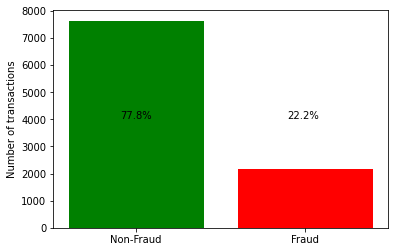

In [34]:
plt.bar(['Non-Fraud','Fraud'], classes, color=['g','r'])
plt.ylabel('Number of transactions')
plt.annotate("{0:.4}%".format(normal_share),(0.2, 0.5), xycoords='axes fraction')
plt.annotate("{0:.4}%".format(fraud_share),(0.7, 0.5), xycoords='axes fraction')
plt.show()
# As per plot we can see it is highly imbalanced 

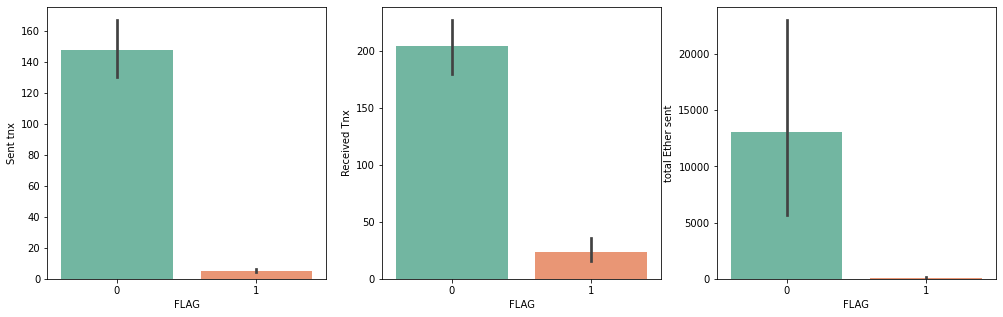

In [35]:
plt.figure(figsize=(17,5))
plt.subplot(1,3,1)
sns.barplot(y = 'Sent tnx', x='FLAG', palette='Set2', data = Ether)
plt.subplot(1,3,2)
sns.barplot(y = 'Received Tnx', x='FLAG', palette='Set2', data = Ether)
plt.subplot(1,3,3)
sns.barplot(y = 'total Ether sent', x='FLAG', palette='Set2', data = Ether)
plt.show()

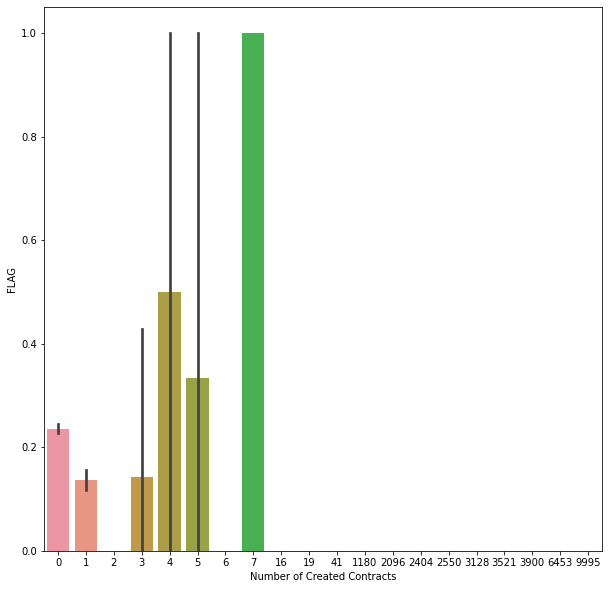

In [36]:
# More the contacts a person has, the more probable they are being victims of a scam.
plt.figure(figsize=(10,10))
sns.barplot(Ether['Number of Created Contracts'],Ether['FLAG'])
plt.show()

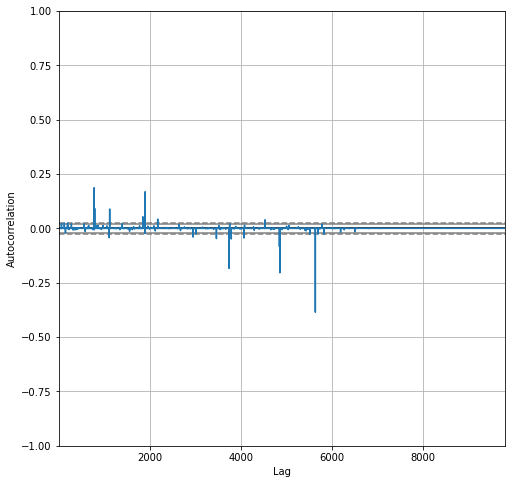

In [37]:
from pandas.plotting import lag_plot,autocorrelation_plot
plt.figure(figsize=(8,8))
autocorrelation_plot(Ether['total ether balance'])
plt.show()
#The bulk of the data points seem random, as shown by the autocorrelation plot, with the majority of them falling inside the 99 percent confidence range.

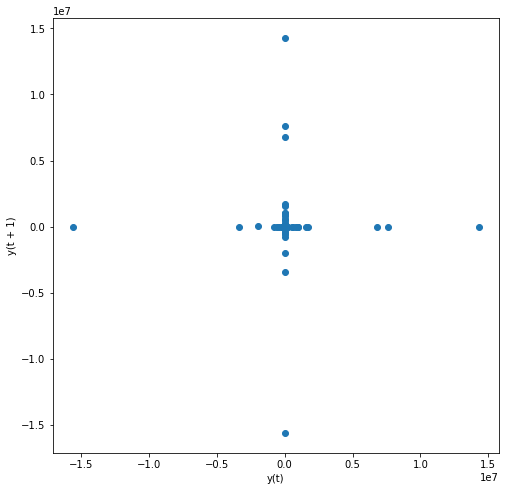

In [38]:
#Many  points are grouped near the centre of the lag plot; the data contains just few non-zero value, but the dots are mostly non-zero and therefore do not follow a trend.
plt.figure(figsize=(8,8))
lag_plot(Ether['total ether balance'])
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feaf6cb4d50>,
      dtype=object)

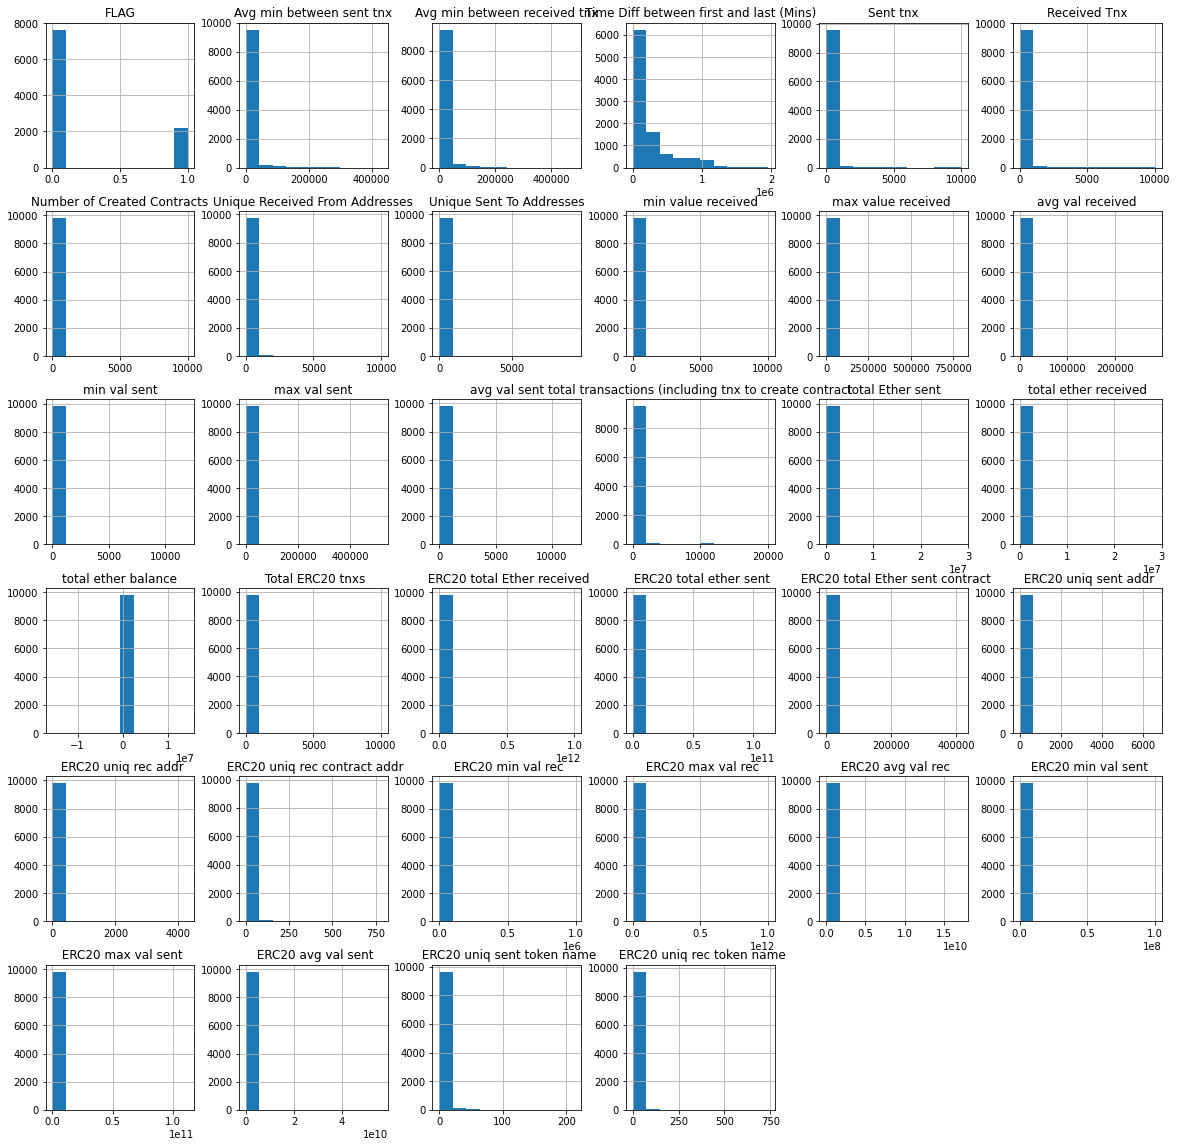

In [39]:
# As per plot the data is severely skewed, with the left tail carrying the majority of the weight.
Ether.hist(figsize=(20,20))

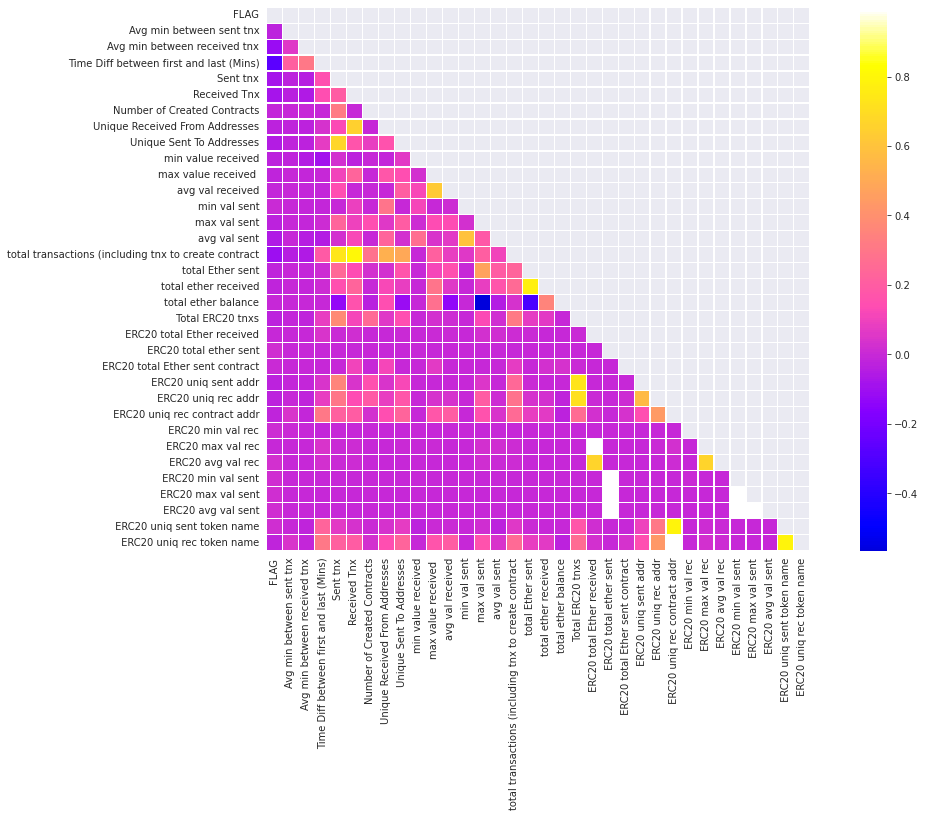

In [40]:
# Correlation matrix
corr = Ether.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('dark'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='gnuplot2', center=0, linewidths=0.1, square=True)

In [41]:
Ether.corr()['FLAG'].sort_values(ascending=False)[1:]

 ERC20 avg val rec                                      0.024147
 ERC20 min val sent                                     0.019056
 ERC20 avg val sent                                     0.018831
 ERC20 max val sent                                     0.018825
 ERC20 total ether sent                                 0.018500
 ERC20 uniq sent token name                             0.017581
 ERC20 min val rec                                      0.011292
 ERC20 total Ether sent contract                        0.008111
min val sent                                            0.006592
total ether balance                                    -0.003238
 ERC20 max val rec                                     -0.004329
 ERC20 total Ether received                            -0.004527
avg val received                                       -0.011884
Number of Created Contracts                            -0.013752
total Ether sent                                       -0.015034
total ether received     

In [42]:
High_correlated = ['Address','total transactions (including tnx to create contract',  ' ERC20 avg val rec',
        ' ERC20 avg val rec',' ERC20 max val rec', ' ERC20 min val rec', ' ERC20 uniq rec contract addr', 'max val sent', ' ERC20 avg val sent',
        ' ERC20 min val sent', ' ERC20 max val sent', ' Total ERC20 tnxs', 'Unique Sent To Addresses',
        'Unique Received From Addresses', 'total ether received', ' ERC20 uniq sent token name', 'min value received', 'min val sent', ' ERC20 uniq rec addr' ]
Ether.drop(High_correlated, axis=1, inplace=True)

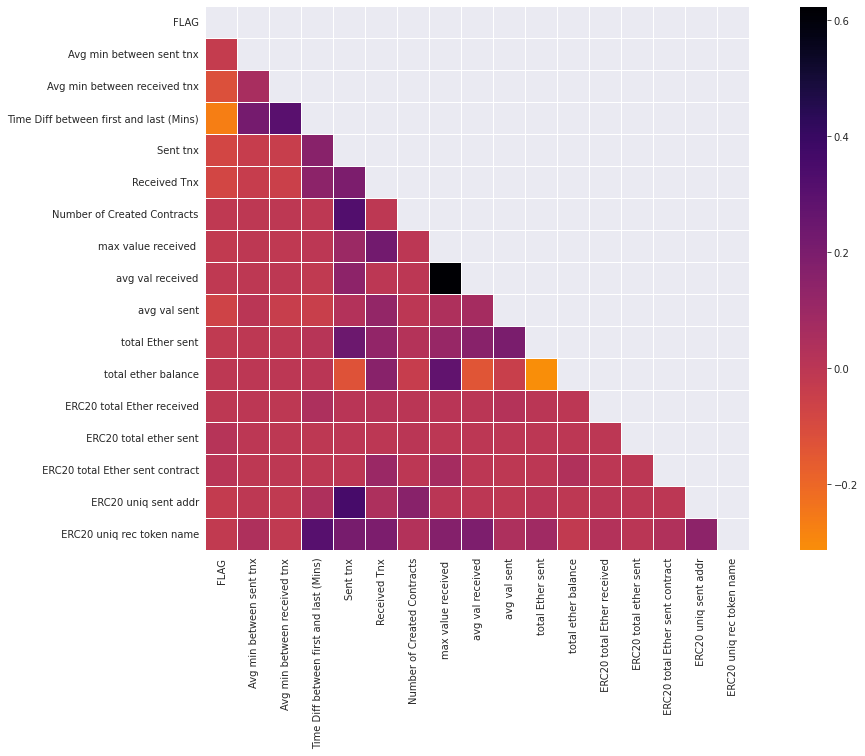

In [43]:
corr = Ether.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('dark'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='inferno_r', center=0, linewidths=0.1, square=True)

In [44]:
Ether.shape

(9816, 17)

In [45]:
Ether.columns

Index(['FLAG', 'Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'max value received ',
       'avg val received', 'avg val sent', 'total Ether sent',
       'total ether balance', ' ERC20 total Ether received',
       ' ERC20 total ether sent', ' ERC20 total Ether sent contract',
       ' ERC20 uniq sent addr', ' ERC20 uniq rec token name'],
      dtype='object')

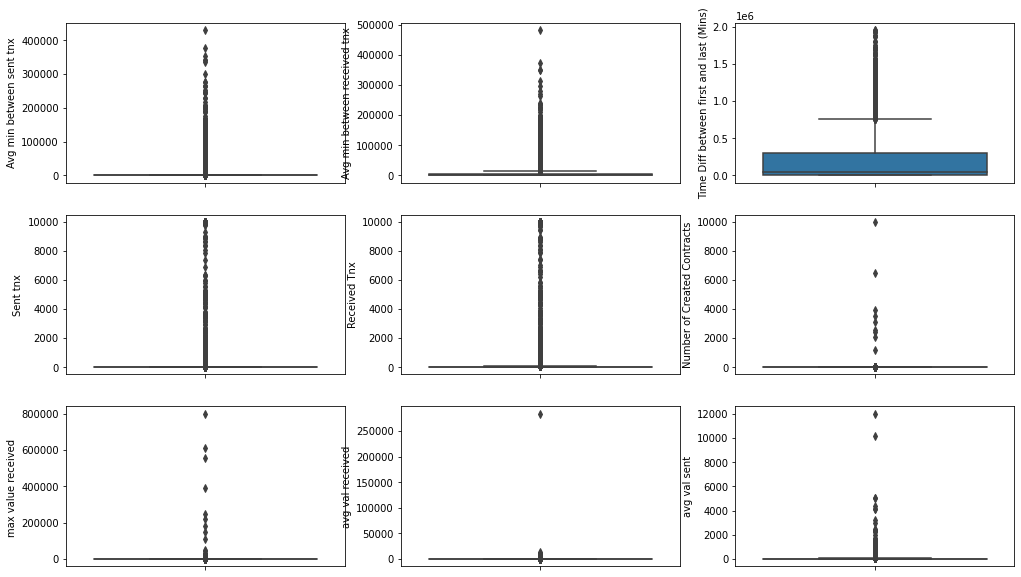

In [46]:
#Checking  outliers in  columns
plt.figure(figsize=(17,10))
plt.subplot(3,3,1)
sns.boxplot(y = 'Avg min between sent tnx', data = Ether)

plt.subplot(3,3,2)
sns.boxplot(y = 'Avg min between received tnx', data = Ether)

plt.subplot(3,3,3)
sns.boxplot(y = 'Time Diff between first and last (Mins)',  data = Ether)

plt.subplot(3,3,4)
sns.boxplot(y = 'Sent tnx',  data = Ether)

plt.subplot(3,3,5)
sns.boxplot(y = 'Received Tnx',  data = Ether)

plt.subplot(3,3,6)
sns.boxplot(y = 'Number of Created Contracts',  data = Ether)

plt.subplot(3,3,7)
sns.boxplot(y = 'max value received ',  data = Ether)

plt.subplot(3,3,8)
sns.boxplot(y = 'avg val received',  data = Ether)

plt.subplot(3,3,9)
sns.boxplot(y = 'avg val sent',  data = Ether)

plt.show()

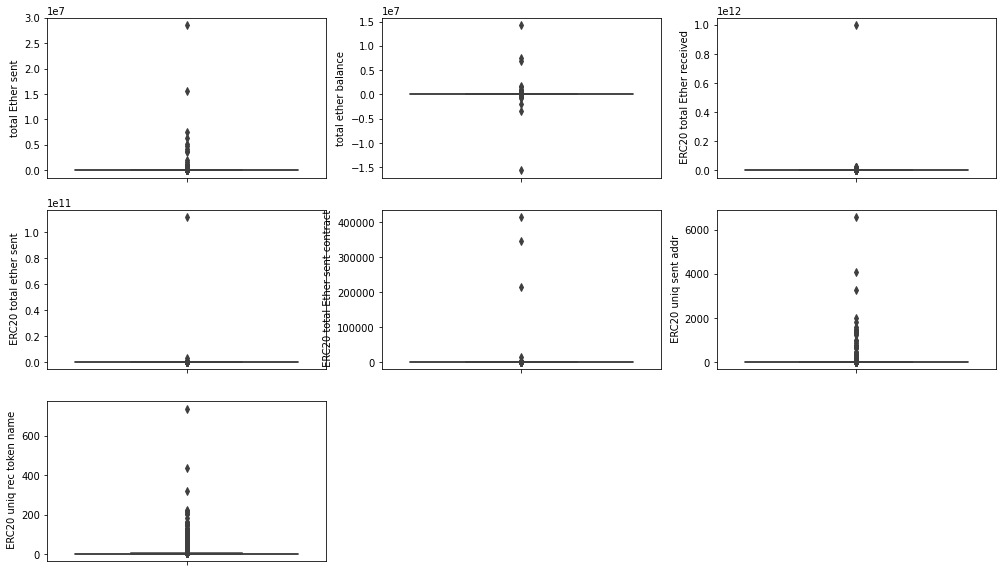

In [47]:
plt.figure(figsize=(17,10))
plt.subplot(3,3,1)
sns.boxplot(y = 'total Ether sent',  data = Ether)

plt.subplot(3,3,2)
sns.boxplot(y = 'total ether balance',  data = Ether)

plt.subplot(3,3,3)
sns.boxplot(y = ' ERC20 total Ether received',  data = Ether)

plt.subplot(3,3,4)
sns.boxplot(y = ' ERC20 total ether sent',  data = Ether)

plt.subplot(3,3,5)
sns.boxplot(y = ' ERC20 total Ether sent contract',  data = Ether)

plt.subplot(3,3,6)
sns.boxplot(y = ' ERC20 uniq sent addr',  data = Ether)

plt.subplot(3,3,7)
sns.boxplot(y = ' ERC20 uniq rec token name',  data = Ether)


plt.show()

In [48]:

Ether.head()

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,max value received,avg val received,avg val sent,total Ether sent,total ether balance,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec token name
0,0,844.26,1093.71,704785.63,721,89,0,45.806785,6.589513,1.200681,865.691093,-279.224419,3.558854e+07,3.560317e+07,0.0,30.0,57.0
1,0,12709.07,2958.44,1218216.73,94,8,0,2.613269,0.385685,0.032844,3.087297,-0.001819,4.034283e+02,2.260809e+00,0.0,1.0,7.0
2,0,246194.54,2434.02,516729.30,2,10,0,1.165453,0.358906,1.794308,3.588616,0.000441,5.215121e+02,0.000000e+00,0.0,0.0,8.0
3,0,10219.60,15785.09,397555.90,25,9,0,500.000000,99.488840,70.001834,1750.045862,-854.646303,1.711105e+04,1.141223e+04,0.0,2.0,11.0
4,0,36.61,10707.77,382472.42,4598,20,1,12.802411,2.671095,0.022688,104.318883,-50.896986,1.628297e+05,1.235399e+05,0.0,4.0,27.0


In [49]:
Ether.shape

(9816, 17)

In [50]:
y = Ether.iloc[:, 0]
X = Ether.iloc[:, 1:]
print(X.shape, y.shape)

(9816, 16) (9816,)


In [51]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7362, 16) (7362,)
(2454, 16) (2454,)


In [52]:
# Normalize   training features

from sklearn.preprocessing import PowerTransformer

N = PowerTransformer()
N_train = N.fit_transform(X_train)

In [53]:
N_Ether = pd.DataFrame(N_train, columns=X_train.columns)
N_Ether

,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,max value received,avg val received,avg val sent,total Ether sent,total ether balance,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec token name
0,-1.103888,-1.181980,-0.798012,-0.599250,-0.995041,-0.396005,-0.913178,-0.592408,-0.485117,-0.896138,-0.006456,-0.823901,-0.421901,-0.041471,-0.449933,-0.984943
1,-1.103888,-1.181980,-1.382659,-0.599250,-0.995041,-0.396005,-0.407865,0.041961,0.124338,-0.510521,-0.006456,-0.823901,-0.421901,-0.041471,-0.449933,-0.984943
2,0.876812,0.920351,1.075613,1.381289,1.247305,-0.396005,0.463300,-0.444223,-0.176052,0.758522,-0.006456,1.440102,2.418692,-0.041471,2.029552,1.204820
3,0.741015,0.628416,0.722708,1.557658,1.271570,-0.396005,1.320879,1.180727,1.165092,1.663794,-0.006455,1.717369,2.445875,-0.041471,2.347316,0.921529
4,0.064932,0.376728,1.558704,1.973377,1.936325,-0.396005,1.121506,0.330895,0.614243,1.902135,-0.006461,1.302258,2.313990,-0.041471,2.029552,1.204820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7357,0.604712,-1.181980,-0.902030,-0.215424,-0.995041,-0.396005,1.100913,1.453155,1.339176,0.787255,-0.006456,-0.823901,-0.421901,-0.041471,-0.449933,-0.984943
7358,1.523270,0.897689,1.382551,1.325400,0.879601,-0.396005,1.626532,1.426667,1.387999,1.643555,-0.007016,1.713029,2.444807,-0.041471,2.258324,1.752163
7359,-1.103888,0.970933,0.851925,-1.399059,0.980840,2.525118,-0.867335,-0.637738,-1.137802,-1.252619,-0.006351,-0.001872,-0.421901,-0.041471,-0.449933,1.087524
7360,1.135924,1.090969,1.315389,1.491494,1.190541,-0.396005,0.977238,0.646653,0.787638,1.393850,-0.007501,-0.823901,-0.421901,-0.041471,-0.449933,-0.984943


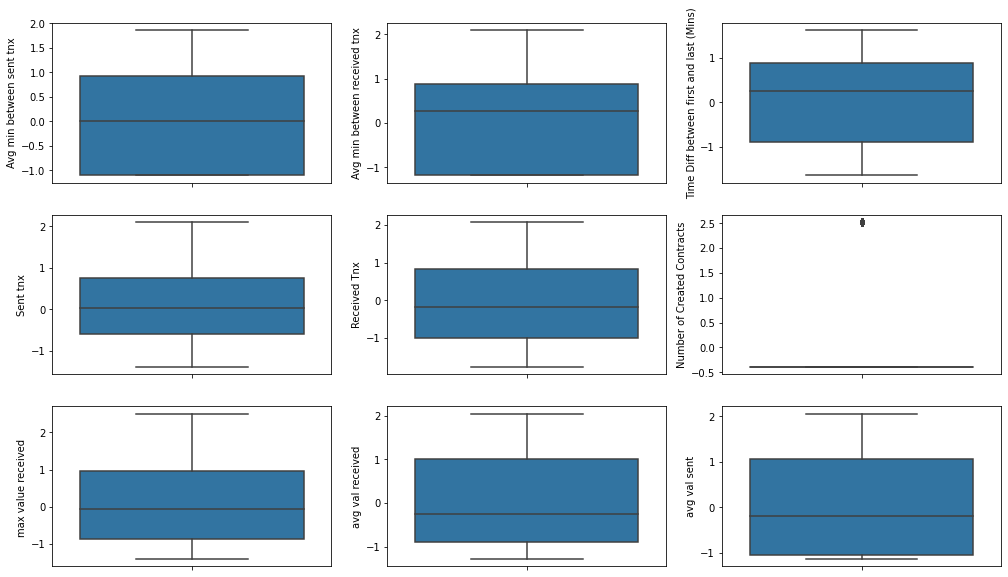

In [54]:
#Checking  outliers in  columns
plt.figure(figsize=(17,10))
plt.subplot(3,3,1)
sns.boxplot(y = 'Avg min between sent tnx', data = N_Ether)

plt.subplot(3,3,2)
sns.boxplot(y = 'Avg min between received tnx', data = N_Ether)

plt.subplot(3,3,3)
sns.boxplot(y = 'Time Diff between first and last (Mins)',  data = N_Ether)

plt.subplot(3,3,4)
sns.boxplot(y = 'Sent tnx',  data = N_Ether)

plt.subplot(3,3,5)
sns.boxplot(y = 'Received Tnx',  data = N_Ether)

plt.subplot(3,3,6)
sns.boxplot(y = 'Number of Created Contracts',  data = N_Ether)

plt.subplot(3,3,7)
sns.boxplot(y = 'max value received ',  data = N_Ether)

plt.subplot(3,3,8)
sns.boxplot(y = 'avg val received',  data = N_Ether)

plt.subplot(3,3,9)
sns.boxplot(y = 'avg val sent',  data = N_Ether)

plt.show()

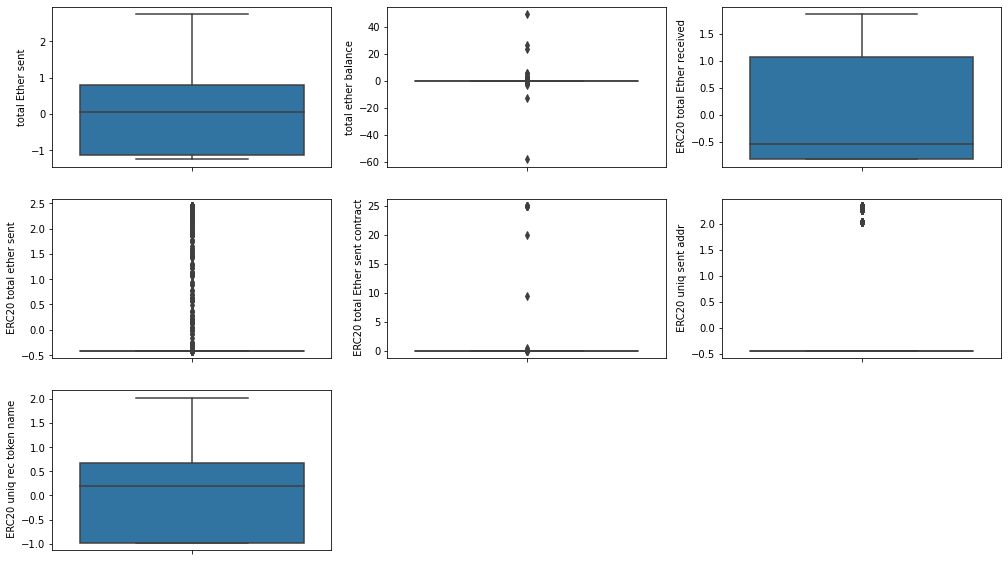

In [55]:
plt.figure(figsize=(17,10))
plt.subplot(3,3,1)
sns.boxplot(y = 'total Ether sent',  data = N_Ether)

plt.subplot(3,3,2)
sns.boxplot(y = 'total ether balance',  data = N_Ether)

plt.subplot(3,3,3)
sns.boxplot(y = ' ERC20 total Ether received',  data = N_Ether)

plt.subplot(3,3,4)
sns.boxplot(y = ' ERC20 total ether sent',  data = N_Ether)

plt.subplot(3,3,5)
sns.boxplot(y = ' ERC20 total Ether sent contract',  data = N_Ether)

plt.subplot(3,3,6)
sns.boxplot(y = ' ERC20 uniq sent addr',  data = N_Ether)

plt.subplot(3,3,7)
sns.boxplot(y = ' ERC20 uniq rec token name',  data = N_Ether)


plt.show()

**Handling the imbalance**

In [56]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
print(f'Before SMOTE: {N_train.shape, y_train.shape}')

x_resample, y_resample = oversample.fit_resample(N_train, y_train)
print(f'After SMOTE: {x_resample.shape, y_resample.shape}')

Before SMOTE: ((7362, 16), (7362,))
After SMOTE: ((11456, 16), (11456,))


**Modeling**

In [57]:
num_cv_splits = 3
skf = model_selection.StratifiedKFold(n_splits=num_cv_splits, shuffle=True, random_state=0)

In [58]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression
from sklearn import metrics
from sklearn import linear_model

num_C = [0.001, 0.01, 0.1, 1.0]
auc = np.zeros((len(num_C), num_cv_splits))
cv_num = 0
for train_index, test_index in skf.split(x_resample, y_resample):
    X_train_cv, X_test_cv = x_resample[train_index], x_resample[test_index]
    y_train_cv, y_test_cv = y_resample[train_index], y_resample[test_index]
    for C_id, C_val in enumerate(num_C):
        LR = linear_model.LogisticRegression(C=C_val, random_state=0, solver='lbfgs', max_iter=1000, n_jobs=-1)
        LR.fit(X_train_cv, y_train_cv)
        auc[C_id, cv_num] = metrics.roc_auc_score(y_true = y_test_cv, y_score = LR.predict_proba(X_test_cv)[:,1])
        print('C_val =', C_val, '; auc =', auc[C_id, cv_num], '; cv_num =', cv_num)
    cv_num += 1
mean_auc = np.mean(auc, axis=1)
print('Best C:', num_C[np.argmax(mean_auc)])
print('Best auc corresponding to Best C:', mean_auc[np.argmax(mean_auc)])

C_val = 0.001 ; auc = 0.8977436721619004 ; cv_num = 0
C_val = 0.01 ; auc = 0.930163540572488 ; cv_num = 0
C_val = 0.1 ; auc = 0.9414303697832531 ; cv_num = 0
C_val = 1.0 ; auc = 0.9439546485509531 ; cv_num = 0
C_val = 0.001 ; auc = 0.9111900367232646 ; cv_num = 1
C_val = 0.01 ; auc = 0.9369802451325906 ; cv_num = 1
C_val = 0.1 ; auc = 0.9461251333583822 ; cv_num = 1
C_val = 1.0 ; auc = 0.9479396301344692 ; cv_num = 1
C_val = 0.001 ; auc = 0.9110090577537792 ; cv_num = 2
C_val = 0.01 ; auc = 0.9418535508101598 ; cv_num = 2
C_val = 0.1 ; auc = 0.9503523465945682 ; cv_num = 2
C_val = 1.0 ; auc = 0.9508778274781774 ; cv_num = 2
Best C: 1.0
Best auc corresponding to Best C: 0.9475907020545332


In [59]:
# Transform test features
test_norm = N.transform(X_test)

 Logistic Regression
[[1673  236]
 [  53  492]]
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      1909
           1       0.68      0.90      0.77       545

    accuracy                           0.88      2454
   macro avg       0.82      0.89      0.85      2454
weighted avg       0.90      0.88      0.89      2454



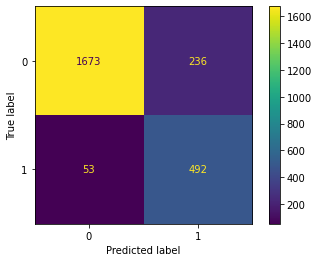

In [60]:

print(" Logistic Regression")
LR_pred_test = LR.predict(test_norm)

print(confusion_matrix(y_test, LR_pred_test))
print(classification_report(y_test, LR_pred_test))
plot_confusion_matrix(LR, test_norm, y_test)

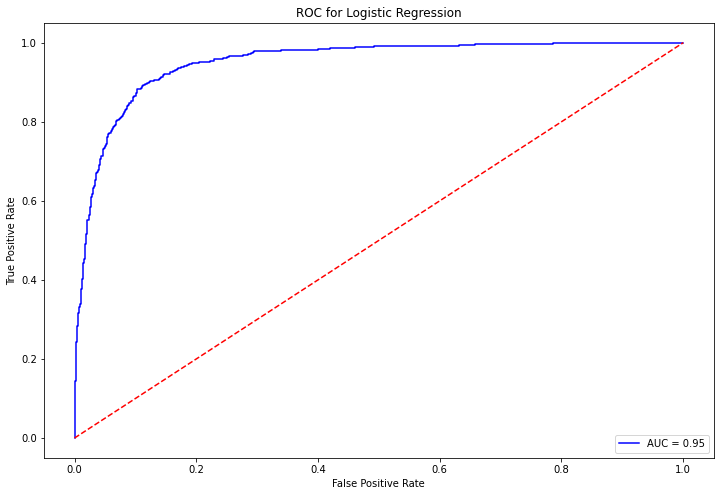

In [61]:
# Plot for Logistic Regression
from sklearn.metrics import  auc

prob = LR.predict_proba(test_norm)
pre = prob[:,1]
fpr, tpr, threshold = roc_curve(y_test, pre)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,8))
plt.title('ROC for Logistic Regression')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [62]:
# Decision Tree

from sklearn import tree

num_depth = range(2, 7)
num_min_samples_leaf = [30,50,100]
num_min_samples_split = [2,31]
auc = np.zeros((len(num_depth)*len(num_min_samples_leaf)*len(num_min_samples_split), num_cv_splits))
cv_num = 0
for train_index, test_index in skf.split(x_resample, y_resample):
    X_train_cv, X_test_cv = x_resample[train_index], x_resample[test_index]
    y_train_cv, y_test_cv = y_resample[train_index], y_resample[test_index]
    for depth_id, depth in enumerate(num_depth):
        for min_samples_leaf_id, min_samples_leaf in enumerate(num_min_samples_leaf):
            for min_samples_split_id, min_samples_split in enumerate(num_min_samples_split):
                DT = tree.DecisionTreeClassifier(criterion='entropy', max_depth=depth,
                        min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, random_state=0)
                DT.fit(X_train_cv, y_train_cv)
                auc_id = depth_id*len(num_min_samples_leaf)*len(num_min_samples_split)+\
                            min_samples_leaf_id*len(num_min_samples_split)+min_samples_split_id
                auc[auc_id, cv_num] = metrics.roc_auc_score(y_true = y_test_cv, y_score = DT.predict_proba(X_test_cv)[:,1])
                print('depth =', depth, '; min_samples_leaf =', min_samples_leaf, '; min_samples_split =',
                      min_samples_split, '; auc =', auc[auc_id, cv_num], '; cv_num =', cv_num)
    cv_num += 1
mean_auc = np.mean(auc, axis=1)
depth_id = np.argmax(mean_auc)//(len(num_min_samples_leaf)*len(num_min_samples_split))
min_samples_leaf_id = (np.argmax(mean_auc) - depth_id*len(num_min_samples_leaf)*len(num_min_samples_split))//len(
                       num_min_samples_split)
min_samples_split_id = (np.argmax(mean_auc) - depth_id*len(num_min_samples_leaf)*len(num_min_samples_split))%len(
                       num_min_samples_split)
print('Best depth:', num_depth[depth_id])
print('Best min_samples_leaf:', num_min_samples_leaf[min_samples_leaf_id])
print('Best min_samples_split:', num_min_samples_leaf[min_samples_split_id])
print('Best auc corresponding to Best depth, min_samples_leaf & min_samples_split :', mean_auc[np.argmax(mean_auc)])


depth = 2 ; min_samples_leaf = 30 ; min_samples_split = 2 ; auc = 0.9429862404317931 ; cv_num = 0
depth = 2 ; min_samples_leaf = 30 ; min_samples_split = 31 ; auc = 0.9429862404317931 ; cv_num = 0
depth = 2 ; min_samples_leaf = 50 ; min_samples_split = 2 ; auc = 0.9351823410189815 ; cv_num = 0
depth = 2 ; min_samples_leaf = 50 ; min_samples_split = 31 ; auc = 0.9351823410189815 ; cv_num = 0
depth = 2 ; min_samples_leaf = 100 ; min_samples_split = 2 ; auc = 0.9351823410189815 ; cv_num = 0
depth = 2 ; min_samples_leaf = 100 ; min_samples_split = 31 ; auc = 0.9351823410189815 ; cv_num = 0
depth = 3 ; min_samples_leaf = 30 ; min_samples_split = 2 ; auc = 0.9640283419130654 ; cv_num = 0
depth = 3 ; min_samples_leaf = 30 ; min_samples_split = 31 ; auc = 0.9640283419130654 ; cv_num = 0
depth = 3 ; min_samples_leaf = 50 ; min_samples_split = 2 ; auc = 0.9580515551850013 ; cv_num = 0
depth = 3 ; min_samples_leaf = 50 ; min_samples_split = 31 ; auc = 0.9580515551850013 ; cv_num = 0
depth = 3 ; m

In [63]:


print(" DT Test Results")
DT_pred_test = DT.predict(test_norm)

print(confusion_matrix(y_test, DT_pred_test))
print(classification_report(y_test, DT_pred_test))

 DT Test Results
[[1777  132]
 [  44  501]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1909
           1       0.79      0.92      0.85       545

    accuracy                           0.93      2454
   macro avg       0.88      0.93      0.90      2454
weighted avg       0.93      0.93      0.93      2454



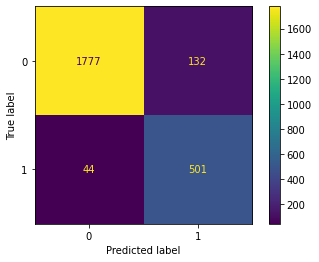

In [64]:
plot_confusion_matrix(DT, test_norm, y_test)

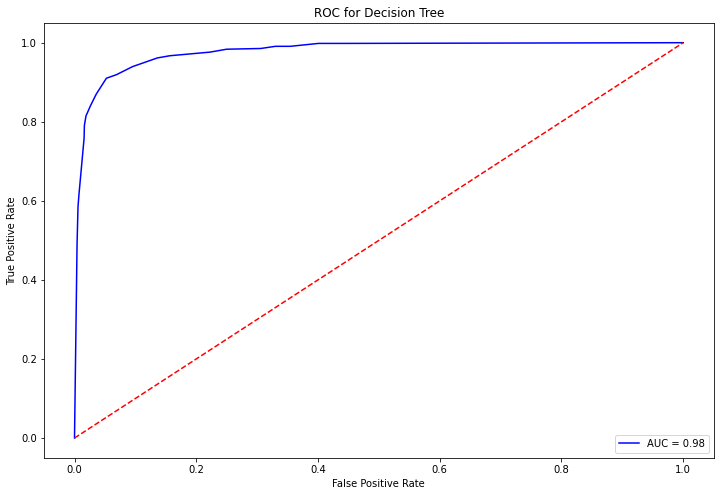

In [65]:
# Plot for Decision Tree
from sklearn.metrics import  auc

prob = DT.predict_proba(test_norm)
pre = prob[:,1]
fpr, tpr, threshold = roc_curve(y_test, pre)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,8))
plt.title('ROC for Decision Tree')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [66]:
# Random Forest

from sklearn import ensemble

initial_trees = 801
num_trees = 899
tree_increment = 1
trees = range(initial_trees, num_trees+1, tree_increment)
auc = np.zeros((len(trees), num_cv_splits))
cv_num = 0
for train_index, test_index in skf.split(x_resample, y_resample):
    X_train_cv, X_test_cv = x_resample[train_index], x_resample[test_index]
    y_train_cv, y_test_cv = y_resample[train_index], y_resample[test_index]
    clf = ensemble.RandomForestClassifier(criterion='entropy', min_samples_leaf=30, warm_start=True, n_jobs=-1,
                                          random_state=0)
    for tree_id, tree in enumerate(trees):
        clf.set_params(n_estimators=tree)
        clf.fit(X_train_cv, y_train_cv)
        auc[tree_id, cv_num] = metrics.roc_auc_score(y_true = y_test_cv, y_score = clf.predict_proba(X_test_cv)[:,1])
        print('num_trees =', tree, '; auc =', auc[tree_id, cv_num], '; cv_num =', cv_num)
    cv_num += 1
mean_auc = np.mean(auc, axis=1)
print('Best num_trees:', trees[np.argmax(mean_auc)])
print('Best auc corresponding to Best num_trees :', mean_auc[np.argmax(mean_auc)])

num_trees = 801 ; auc = 0.9918907133199311 ; cv_num = 0
num_trees = 802 ; auc = 0.9918912618376992 ; cv_num = 0
num_trees = 803 ; auc = 0.9918912618376992 ; cv_num = 0
num_trees = 804 ; auc = 0.9918942786854225 ; cv_num = 0
num_trees = 805 ; auc = 0.9918898905432795 ; cv_num = 0
num_trees = 806 ; auc = 0.9918887935077437 ; cv_num = 0
num_trees = 807 ; auc = 0.991887970731092 ; cv_num = 0
num_trees = 808 ; auc = 0.9918879707310919 ; cv_num = 0
num_trees = 809 ; auc = 0.991887422213324 ; cv_num = 0
num_trees = 810 ; auc = 0.991887422213324 ; cv_num = 0
num_trees = 811 ; auc = 0.9918956499798419 ; cv_num = 0
num_trees = 812 ; auc = 0.9918986668275651 ; cv_num = 0
num_trees = 813 ; auc = 0.9919016836752884 ; cv_num = 0
num_trees = 814 ; auc = 0.9919052490407795 ; cv_num = 0
num_trees = 815 ; auc = 0.9919079916296188 ; cv_num = 0
num_trees = 816 ; auc = 0.9919052490407795 ; cv_num = 0
num_trees = 817 ; auc = 0.9919055232996635 ; cv_num = 0
num_trees = 818 ; auc = 0.9919112827362259 ; cv_num

In [67]:
print("RF Test Results")
RF_pred_test = clf.predict(test_norm)

print(confusion_matrix(y_test, RF_pred_test))
print(classification_report(y_test, RF_pred_test))


RF Test Results
[[1811   98]
 [  24  521]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1909
           1       0.84      0.96      0.90       545

    accuracy                           0.95      2454
   macro avg       0.91      0.95      0.93      2454
weighted avg       0.95      0.95      0.95      2454



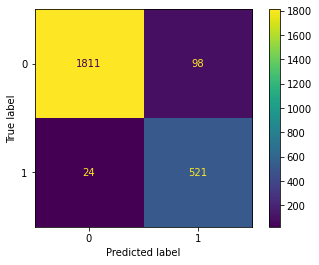

In [68]:
plot_confusion_matrix(clf, test_norm, y_test)

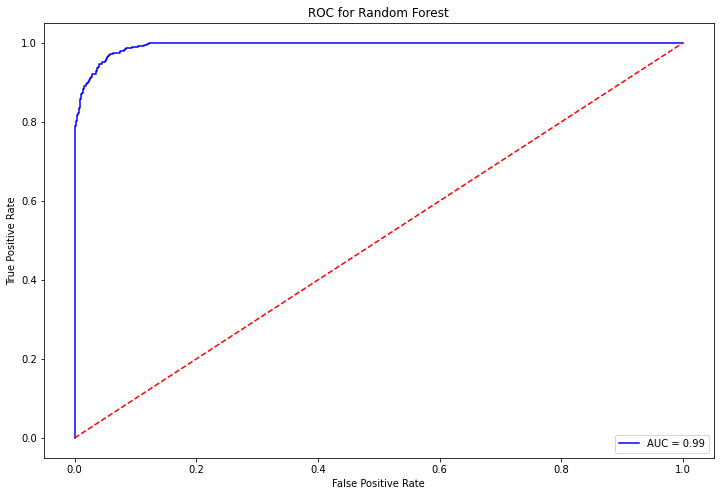

In [69]:
# Plot for Random Forest
from sklearn.metrics import  auc

prob = clf.predict_proba(test_norm)
pre = prob[:,1]
fpr, tpr, threshold = roc_curve(y_test, pre)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,8))
plt.title('ROC for Random Forest')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1909
           1       0.87      0.96      0.91       545

    accuracy                           0.96      2454
   macro avg       0.93      0.96      0.94      2454
weighted avg       0.96      0.96      0.96      2454

[[1829   80]
 [  22  523]]


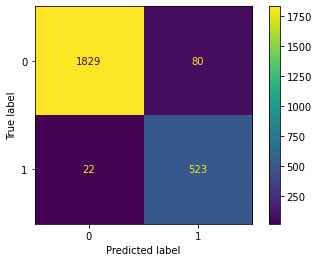

In [70]:
#XGB Classifier

import xgboost as xgb

xgb_T = xgb.XGBClassifier(random_state=42)
xgb_T.fit(x_resample, y_resample)
preds_xgb = xgb_T.predict(test_norm)

print(classification_report(y_test, preds_xgb))
print(confusion_matrix(y_test, preds_xgb))
plot_confusion_matrix(xgb_T, test_norm, y_test)

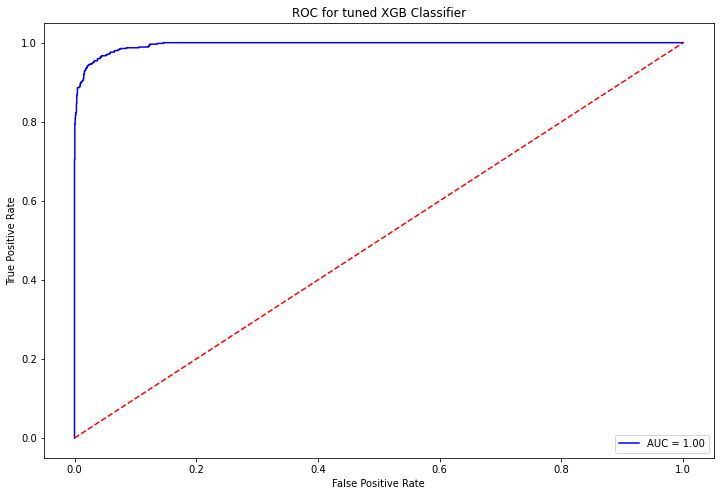

In [71]:
# Plot for AUC XGB Classifier
from sklearn.metrics import  auc

prob = xgb_T.predict_proba(test_norm)
pre = prob[:,1]
fpr, tpr, threshold = roc_curve(y_test, pre)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,8))
plt.title('ROC for tuned XGB Classifier')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Multi-layer Perceptron**

In [72]:
from sklearn.neural_network import MLPClassifier

In [73]:
MLP = MLPClassifier(max_iter=500, activation='relu')
MLP

MLPClassifier(max_iter=500)

In [74]:
MLP.fit(x_resample, y_resample)

MLPClassifier(max_iter=500)

In [75]:
predic = MLP.predict(test_norm)
predic

array([0, 1, 1, ..., 1, 0, 1])

In [76]:
from sklearn.metrics import classification_report,confusion_matrix

confusion_matrix(y_test,predic)

array([[1863,   46],
       [  25,  520]])

In [77]:
print(classification_report(y_test,predic))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1909
           1       0.92      0.95      0.94       545

    accuracy                           0.97      2454
   macro avg       0.95      0.97      0.96      2454
weighted avg       0.97      0.97      0.97      2454



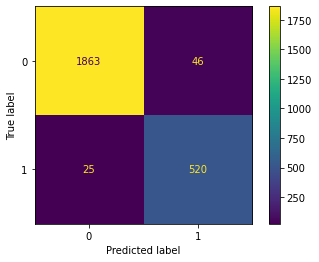

In [78]:
plot_confusion_matrix(MLP, test_norm, y_test)

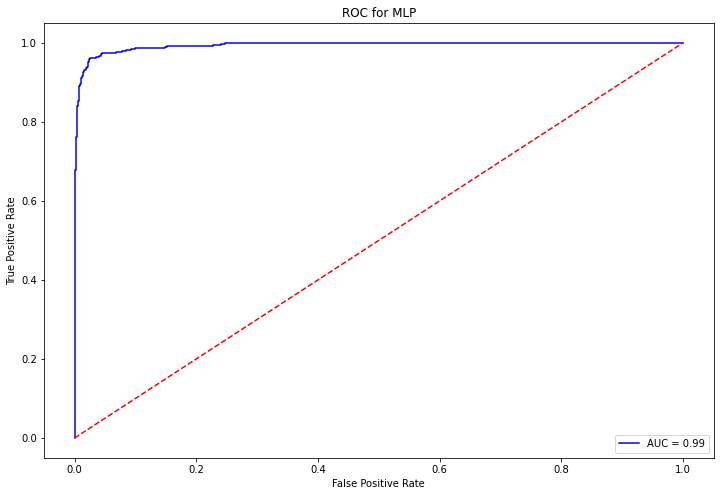

In [79]:
# Plot for MLP
from sklearn.metrics import  auc

prob = MLP.predict_proba(test_norm)
pre = prob[:,1]
fpr, tpr, threshold = roc_curve(y_test, pre)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,8))
plt.title('ROC for MLP')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [80]:
# Feature importance Through Random Forest 
clf.feature_importances_

array([0.01855306, 0.07259873, 0.17146045, 0.03388597, 0.05811298,
       0.00728119, 0.0450731 , 0.07310202, 0.01324476, 0.04381274,
       0.02007649, 0.17105278, 0.01813361, 0.        , 0.01872068,
       0.23489143])

In [81]:
imp_RF_feature = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": clf.feature_importances_
})

In [82]:
# important predictors 
imp_RF_feature.sort_values(by="Imp", ascending=False)

,Varname,Imp
15,ERC20 uniq rec token name,0.234891
2,Time Diff between first and last (Mins),0.171460
11,ERC20 total Ether received,0.171053
7,avg val received,0.073102
1,Avg min between received tnx,0.072599
4,Received Tnx,0.058113
6,max value received,0.045073
9,total Ether sent,0.043813
3,Sent tnx,0.033886
10,total ether balance,0.020076


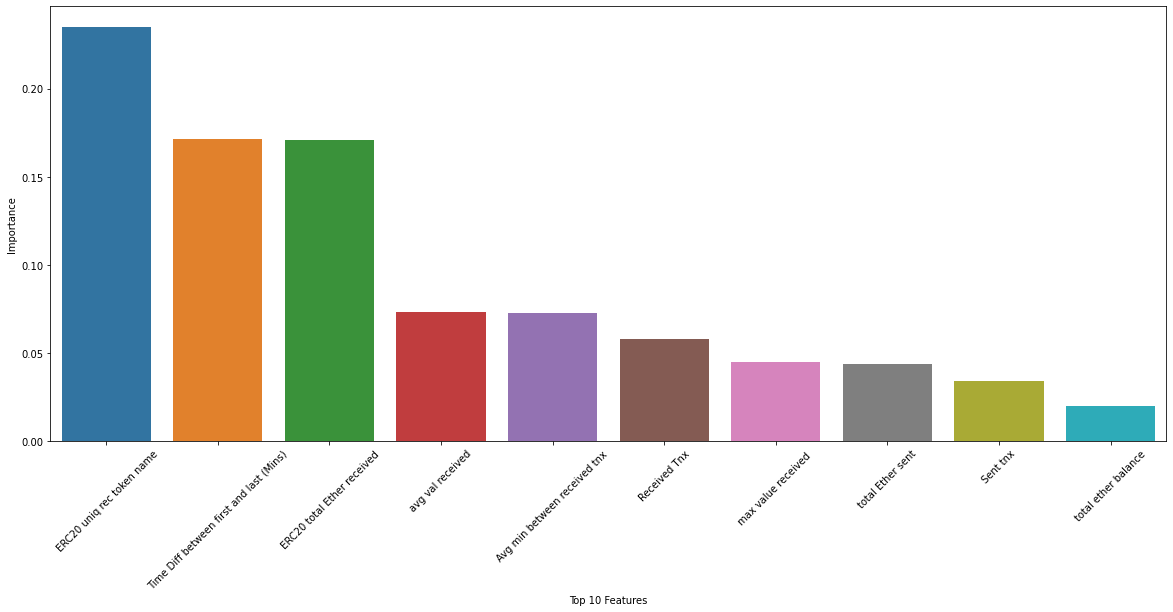

In [89]:
# Plot for top 10 IMPORTANT predictors Random forest
plt.figure(figsize=(20,8))

ax = sns.barplot(x='Varname', y= 'Imp', data=imp_RF_feature.sort_values(by="Imp", ascending=False)[0:10])
ax.set(xlabel = 'Top 10 Features', ylabel = 'Importance')
plt.xticks(rotation=45)
plt.show()